In [1]:
import numpy as np
import pandas as pd

# Define sizes
num_projects = 5
num_infra_types = 3
num_months = 12

P = range(num_projects)
I = range(num_infra_types)
T = range(num_months)

# Generate random benefit scores S[p, t, i]
np.random.seed(42)  # for reproducibility
S = np.random.randint(10, 100, size=(num_projects, num_months, num_infra_types))

# Convert to DataFrame for easy viewing
S_df = pd.DataFrame([
    {'p': p, 't': t, 'i': i, 'S_pti': S[p, t, i]}
    for p in P for t in T for i in I
])

print(S_df.head())



   p  t  i  S_pti
0  0  0  0     61
1  0  0  1     24
2  0  0  2     81
3  0  1  0     70
4  0  1  1     30


In [16]:
delta

{0: 1, 1: 3, 2: 3}

In [37]:
import cplex

In [38]:
import numpy as np
import pandas as pd
import pulp
import matplotlib.pyplot as plt
import seaborn as sns


# --- Problem Setup ---
num_projects = 50
num_infra_types = 3
num_months = 12

P = range(num_projects)
I = range(num_infra_types)
T = range(num_months)

np.random.seed(42)

S = np.random.randint(10, 100, size=(num_projects, num_months, num_infra_types))
delta = {i: np.random.randint(1, 4) for i in I}
b = {t: 500 for t in T}
c = {(i, t): np.random.randint(10, 300) for i in I for t in range(num_months)}

# --- PuLP Model ---
prob = pulp.LpProblem("Infrastructure_Investment", pulp.LpMaximize)

z = pulp.LpVariable.dicts("z", ((p, t, i) for p in P for t in T for i in I), cat='Binary')
x = pulp.LpVariable.dicts("x", ((p, tau, i) for p in P for tau in T for i in I), cat='Binary')

# Objective
prob += pulp.lpSum(z[p, t, i] * S[p, t, i] for p in P for t in T for i in I)

# Constraints
for t in T:
    prob += (
        pulp.lpSum(
            x[p, tau, i] * c.get((i, t - tau), 0)
            for p in P for tau in T for i in I
            if 0 <= t - tau < delta[i]
        ) <= b[t], f"Budget_t{t}"
    )


for p in P:
    for i in I:
        for t in T:
            for tau in T:
                if t <= tau + delta[i]:
                    prob += z[p, t, i] <= x[p, tau, i], f"Link_{p}_{t}_{i}_{tau}"

# --- Solve ---
# prob.solve()
# prob.solve(pulp.CPLEX_CMD(msg=True))
prob.solve(pulp.CPLEX_PY(msg=True))



# --- Visual Output ---
# Create a DataFrame of selected (z=1) decisions
solution = []

for p in P:
    for t in T:
        for i in I:
            if pulp.value(z[p, t, i]) == 1:
                solution.append({
                    'Project': p,
                    'Start_Month': t,
                    'Infrastructure': i,
                    'Score': S[p, t, i]
                })

solution_df = pd.DataFrame(solution)
print("Chosen project-infrastructure-time combinations:")
print(solution_df)





PulpSolverError: CPLEX_PY: Not Available:
No module named 'cplex'


📊 Monthly Budget Usage:
    Month  Used_Budget  Available_Budget
0       0          0.0               500
1       1          0.0               500
2       2          0.0               500
3       3          0.0               500
4       4          0.0               500
5       5          0.0               500
6       6         12.0               500
7       7        148.0               500
8       8        345.0               500
9       9        368.0               500
10     10        389.0               500
11     11        485.0               500


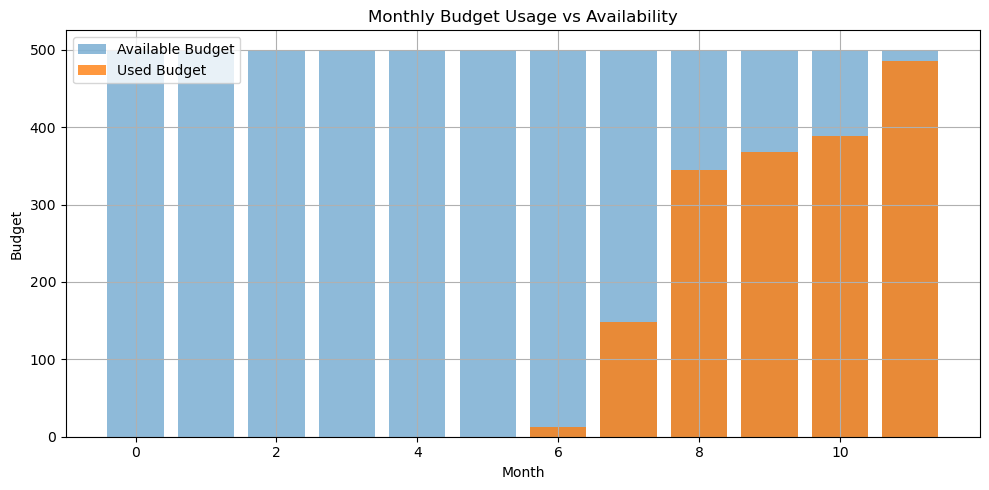

In [18]:
# Track used budget per month
used_budget = {t: 0 for t in T}

for t in T:
    for p in P:
        for tau in T:
            if tau <= t:
                for i in I:
                    cost = c.get((i, t - tau), 0)
                    used_budget[t] += pulp.value(x[p, tau, i]) * cost

# Create a DataFrame for plotting
budget_df = pd.DataFrame({
    'Month': list(T),
    'Used_Budget': [used_budget[t] for t in T],
    'Available_Budget': [b[t] for t in T]
})

print("\n📊 Monthly Budget Usage:")
print(budget_df)

# Plot budget usage
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(budget_df['Month'], budget_df['Available_Budget'], alpha=0.5, label='Available Budget')
plt.bar(budget_df['Month'], budget_df['Used_Budget'], alpha=0.8, label='Used Budget')
plt.xlabel('Month')
plt.ylabel('Budget')
plt.title('Monthly Budget Usage vs Availability')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Nonzero z values (selected project starts):
z(3, 11, 0) = 1


# Gurobi

In [27]:
import numpy as np
import pandas as pd
from gurobipy import Model, GRB, quicksum

# Problem Setup
num_projects = 10
num_infra_types = 3
num_months = 12

P = range(num_projects)
I = range(num_infra_types)
T = range(num_months)

np.random.seed(42)
S = np.random.randint(10, 100, size=(num_projects, num_months, num_infra_types))
delta = {i: np.random.randint(1, 4) for i in I}
b = {t: 500 for t in T}
c = {(i, t): np.random.randint(10, 300) for i in I for t in range(num_months)}

# Create Gurobi model
m = Model("Infrastructure_Investment")
m.Params.OutputFlag = 1  # Turn off to suppress output

# Decision variables
z = m.addVars(P, T, I, vtype=GRB.BINARY, name="z")
x = m.addVars(P, T, I, vtype=GRB.BINARY, name="x")

# Objective function
m.setObjective(quicksum(z[p, t, i] * S[p, t, i] for p in P for t in T for i in I), GRB.MAXIMIZE)

# Budget constraints
for t in T:
    m.addConstr(
        quicksum(
            x[p, tau, i] * c.get((i, t - tau), 0)
            for p in P for tau in T for i in I
            if 0 <= t - tau < delta[i]
        ) <= b[t],
        name=f"Budget_t{t}"
    )

# Linking constraints
for p in P:
    for i in I:
        for t in T:
            for tau in T:
                if t <= tau + delta[i]:
                    m.addConstr(z[p, t, i] <= x[p, tau, i], name=f"Link_{p}_{t}_{i}_{tau}")

# Solve
m.optimize()

# Extract solution
solution = []
for p in P:
    for t in T:
        for i in I:
            if z[p, t, i].X > 0.5:
                solution.append({
                    'Project': p,
                    'Start_Month': t,
                    'Infrastructure': i,
                    'Score': S[p, t, i]
                })

solution_df = pd.DataFrame(solution)
print(solution_df.head())


Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.1.0 24B91)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads



GurobiError: Model too large for size-limited license; visit https://gurobi.com/unrestricted for more information


📊 Monthly Budget Usage:
   Month  Used_Budget  Available_Budget
0      0          0.0               500
1      1          0.0               500
2      2          0.0               500
3      3          0.0               500
4      4          0.0               500
5      5          0.0               500


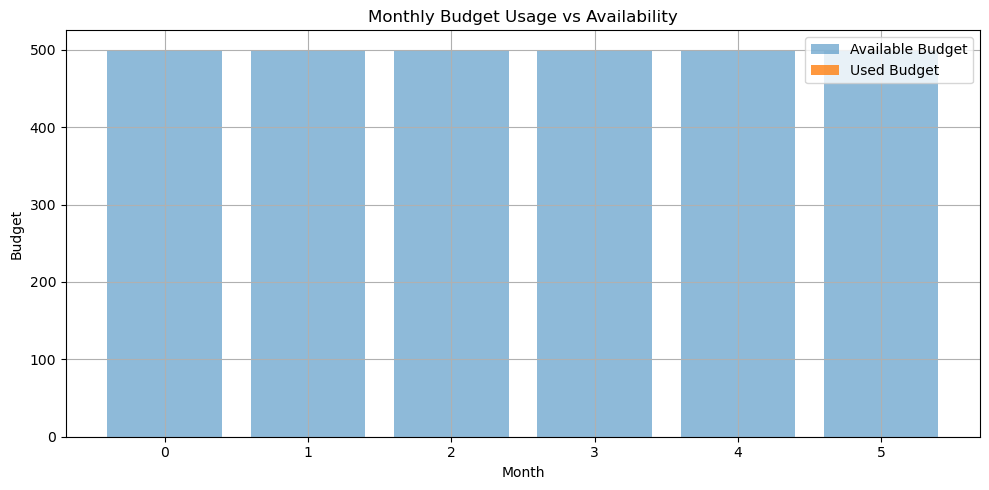

In [26]:
# Track used budget per month
used_budget = {t: 0 for t in T}

for t in T:
    for p in P:
        for tau in T:
            if tau <= t:
                for i in I:
                    cost = c.get((i, t - tau), 0)
                    var_val = x[p, tau, i].X  # Gurobi syntax
                    used_budget[t] += var_val * cost

# Create DataFrame for plotting
budget_df = pd.DataFrame({
    'Month': list(T),
    'Used_Budget': [used_budget[t] for t in T],
    'Available_Budget': [b[t] for t in T]
})

print("\n📊 Monthly Budget Usage:")
print(budget_df)

# Plot budget usage
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(budget_df['Month'], budget_df['Available_Budget'], alpha=0.5, label='Available Budget')
plt.bar(budget_df['Month'], budget_df['Used_Budget'], alpha=0.8, label='Used Budget')
plt.xlabel('Month')
plt.ylabel('Budget')
plt.title('Monthly Budget Usage vs Availability')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

